In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc 

In [20]:
df = pd.read_csv("titanic (1).csv")

In [21]:
print(df.head())
print(df.info())
print(df.isnull().sum())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

In [22]:
df = df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)

# sex to 0/1
df["Sex"] = df["Sex"].map({"male": 0, "female": 1})

# fill missing values
df["Age"] = df["Age"].fillna(df["Age"].median())
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])
df["Embarked"] = df["Embarked"].map({"S": 0, "C": 1, "Q": 2})

# family size feature
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
df = df.drop(["SibSp", "Parch"], axis=1)

y = df["Survived"].values
X = df.drop("Survived", axis=1).values
feature_names = df.drop("Survived", axis=1).columns.tolist()

print("shape:", X.shape)

shape: (891, 6)


In [23]:
def stratified_split(X, y, test_size=0.2, seed=0):
    rng = np.random.RandomState(seed)
    y = np.array(y)
    train_idx = []
    test_idx = []
    for c in np.unique(y):
        idx = np.where(y == c)[0]
        rng.shuffle(idx)
        n_test = int(np.ceil(test_size * len(idx)))
        test_idx.extend(idx[:n_test])
        train_idx.extend(idx[n_test:])
    train_idx = np.array(train_idx, dtype=int)
    test_idx = np.array(test_idx, dtype=int)
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

X_train, X_test, y_train, y_test = stratified_split(X, y, test_size=0.2, seed=0)
print("train:", X_train.shape, "test:", X_test.shape)

train: (712, 6) test: (179, 6)


In [24]:
mean_train = X_train.mean(axis=0)
std_train = X_train.std(axis=0)
std_train[std_train == 0] = 1.0  

X_train_std = (X_train - mean_train) / std_train
X_test_std = (X_test - mean_train) / std_train

In [25]:
pca_mean = X_train_std.mean(axis=0)
X_train_centered = X_train_std - pca_mean
X_test_centered = X_test_std - pca_mean

# SVD: X = U S V^T
U, S, Vt = np.linalg.svd(X_train_centered, full_matrices=False)

# explained variance stuff
n_samples = X_train_centered.shape[0]
explained_var = (S**2) / (n_samples - 1)
total_var = explained_var.sum()
explained_ratio = explained_var / total_var
cum_explained = np.cumsum(explained_ratio)

print("\nExplained variance ratio:")
for i, r in enumerate(explained_ratio):
    print(f"PC{i+1}: {r:.3f}")
print("\nCumulative explained variance:")
for i, c in enumerate(cum_explained):
    print(f"PC1..PC{i+1}: {c:.3f}")


Explained variance ratio:
PC1: 0.301
PC2: 0.237
PC3: 0.179
PC4: 0.122
PC5: 0.108
PC6: 0.053

Cumulative explained variance:
PC1..PC1: 0.301
PC1..PC2: 0.537
PC1..PC3: 0.716
PC1..PC4: 0.839
PC1..PC5: 0.947
PC1..PC6: 1.000


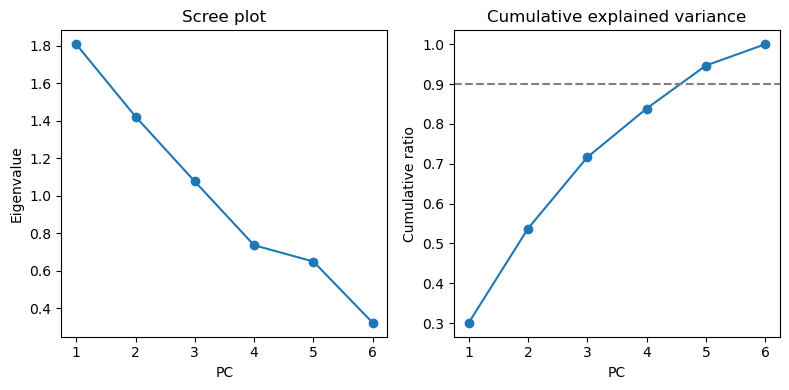

In [26]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(range(1, len(explained_var)+1), explained_var, marker="o")
plt.title("Scree plot")
plt.xlabel("PC")
plt.ylabel("Eigenvalue")

plt.subplot(1,2,2)
plt.plot(range(1, len(cum_explained)+1), cum_explained, marker="o")
plt.axhline(0.9, ls="--", color="gray")
plt.title("Cumulative explained variance")
plt.xlabel("PC")
plt.ylabel("Cumulative ratio")

plt.tight_layout()
plt.show()

In [27]:
k_pca = 3  

if k_pca < 1:
    k_pca = 1
if k_pca > Vt.shape[0]:
    k_pca = Vt.shape[0]

print("\nUsing k_pca =", k_pca)

components = Vt[:k_pca, :]           # (k, d)
X_train_pca = X_train_centered @ components.T
X_test_pca = X_test_centered @ components.T

print("PCA shapes:", X_train_pca.shape, X_test_pca.shape)


Using k_pca = 3
PCA shapes: (712, 3) (179, 3)


In [28]:
def rbf_kernel(X1, X2, gamma):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            diff = X1[i] - X2[j]
            K[i,j] = np.exp(-gamma * np.dot(diff, diff))
    return K

In [29]:
class RBFSVM:
    def __init__(self, C=1.0, gamma=0.5, tol=1e-3, max_passes=10, seed=0):
        self.C = C
        self.gamma = gamma
        self.tol = tol
        self.max_passes = max_passes
        self.seed = seed

    def fit(self, X, y):
        rng = np.random.RandomState(self.seed)
        y_bin = np.where(y == 1, 1.0, -1.0)
        n = X.shape[0]

        self.X = X
        self.y = y_bin
        self.alphas = np.zeros(n)
        self.b = 0.0

        K = rbf_kernel(X, X, self.gamma)

        passes = 0
        while passes < self.max_passes:
            changed = 0
            for i in range(n):
                f_i = np.sum(self.alphas * self.y * K[:, i]) + self.b
                E_i = f_i - self.y[i]

                cond1 = (self.y[i] * E_i < -self.tol and self.alphas[i] < self.C)
                cond2 = (self.y[i] * E_i > self.tol and self.alphas[i] > 0)
                if not (cond1 or cond2):
                    continue

                j = i
                while j == i:
                    j = rng.randint(0, n)

                f_j = np.sum(self.alphas * self.y * K[:, j]) + self.b
                E_j = f_j - self.y[j]

                alpha_i_old = self.alphas[i]
                alpha_j_old = self.alphas[j]

                if self.y[i] != self.y[j]:
                    L = max(0, alpha_j_old - alpha_i_old)
                    H = min(self.C, self.C + alpha_j_old - alpha_i_old)
                else:
                    L = max(0, alpha_i_old + alpha_j_old - self.C)
                    H = min(self.C, alpha_i_old + alpha_j_old)
                if L == H:
                    continue

                eta = 2 * K[i,j] - K[i,i] - K[j,j]
                if eta >= 0:
                    continue

                alpha_j_new = alpha_j_old - self.y[j]*(E_i - E_j)/eta
                if alpha_j_new > H: alpha_j_new = H
                if alpha_j_new < L: alpha_j_new = L
                if abs(alpha_j_new - alpha_j_old) < 1e-5:
                    continue

                alpha_i_new = alpha_i_old + self.y[i]*self.y[j]*(alpha_j_old - alpha_j_new)

                self.alphas[i] = alpha_i_new
                self.alphas[j] = alpha_j_new

                b1 = self.b - E_i \
                     - self.y[i]*(alpha_i_new-alpha_i_old)*K[i,i] \
                     - self.y[j]*(alpha_j_new-alpha_j_old)*K[i,j]
                b2 = self.b - E_j \
                     - self.y[i]*(alpha_i_new-alpha_i_old)*K[i,j] \
                     - self.y[j]*(alpha_j_new-alpha_j_old)*K[j,j]

                if 0 < alpha_i_new < self.C:
                    self.b = b1
                elif 0 < alpha_j_new < self.C:
                    self.b = b2
                else:
                    self.b = 0.5*(b1 + b2)

                changed += 1

            if changed == 0:
                passes += 1
            else:
                passes = 0
            #print("passes:", passes, "changed:", changed)  

        sv_mask = self.alphas > 1e-6
        self.sv_X = self.X[sv_mask]
        self.sv_y = self.y[sv_mask]
        self.sv_alpha = self.alphas[sv_mask]
        #print("support vectors:", self.sv_X.shape[0])

    def decision_function(self, X):
        K = rbf_kernel(X, self.sv_X, self.gamma)
        return K @ (self.sv_alpha * self.sv_y) + self.b

    def predict(self, X):
        scores = self.decision_function(X)
        return (scores >= 0).astype(int)

In [30]:
#metrics

def confusion(y_true, y_pred):
    tn = np.sum((y_true==0) & (y_pred==0))
    fp = np.sum((y_true==0) & (y_pred==1))
    fn = np.sum((y_true==1) & (y_pred==0))
    tp = np.sum((y_true==1) & (y_pred==1))
    return np.array([[tn, fp],[fn, tp]])

def accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def precision(y_true, y_pred):
    cm = confusion(y_true, y_pred)
    tp = cm[1,1]; fp = cm[0,1]
    if tp + fp == 0: return 0.0
    return tp / (tp + fp)

def recall(y_true, y_pred):
    cm = confusion(y_true, y_pred)
    tp = cm[1,1]; fn = cm[1,0]
    if tp + fn == 0: return 0.0
    return tp / (tp + fn)

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    if p + r == 0: return 0.0
    return 2 * p * r / (p + r)

def print_report(name, y_true, y_pred, scores):
    cm = confusion(y_true, y_pred)
    acc = accuracy(y_true, y_pred)
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    f1v = f1(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, scores)
    auc_v = auc(fpr, tpr)

    print("\n", name)
    print("confusion:\n", cm)
    print("accuracy:", acc)
    print("precision:", prec)
    print("recall:", rec)
    print("f1:", f1v)
    print("auc:", auc_v)

    return fpr, tpr, auc_v



In [31]:
C_val = 3
gamma_val = 0.7

rbf_raw = RBFSVM(C=C_val, gamma=gamma_val, tol=1e-3, max_passes=10, seed=0)
rbf_raw.fit(X_train_std, y_train)
pred_raw = rbf_raw.predict(X_test_std)
scores_raw = rbf_raw.decision_function(X_test_std)

rbf_pca = RBFSVM(C=C_val, gamma=gamma_val, tol=1e-3, max_passes=10, seed=0)
rbf_pca.fit(X_train_pca, y_train)
pred_pca = rbf_pca.predict(X_test_pca)
scores_pca = rbf_pca.decision_function(X_test_pca)

fpr_raw, tpr_raw, auc_raw = print_report("RBF SVM (raw)", y_test, pred_raw, scores_raw)
fpr_pca, tpr_pca, auc_pca = print_report("RBF SVM (PCA)", y_test, pred_pca, scores_pca)


# ROC curve





 RBF SVM (raw)
confusion:
 [[89 21]
 [26 43]]
accuracy: 0.7374301675977654
precision: 0.671875
recall: 0.6231884057971014
f1: 0.6466165413533834
auc: 0.7784584980237155

 RBF SVM (PCA)
confusion:
 [[87 23]
 [22 47]]
accuracy: 0.7486033519553073
precision: 0.6714285714285714
recall: 0.6811594202898551
f1: 0.6762589928057554
auc: 0.7838603425559947


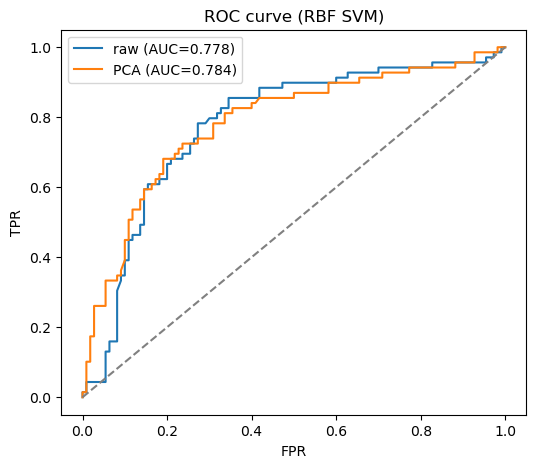

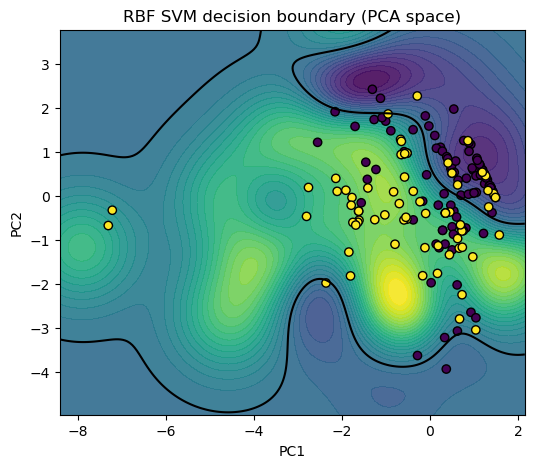

In [32]:
plt.figure(figsize=(6,5))
plt.plot(fpr_raw, tpr_raw, label="raw (AUC=%.3f)" % auc_raw)
plt.plot(fpr_pca, tpr_pca, label="PCA (AUC=%.3f)" % auc_pca)
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve (RBF SVM)")
plt.legend()
plt.show()


if k_pca >= 2:
    X_all = np.vstack([X_train_pca, X_test_pca])
    x_min, x_max = X_all[:,0].min() - 0.5, X_all[:,0].max() + 0.5
    y_min, y_max = X_all[:,1].min() - 0.5, X_all[:,1].max() + 0.5

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]

    
    if k_pca > 2:
        pad = np.zeros((grid.shape[0], k_pca - 2))
        grid_full = np.hstack([grid, pad])
    else:
        grid_full = grid

    Z = rbf_pca.decision_function(grid_full)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(6,5))
    cs = plt.contourf(xx, yy, Z, levels=30, alpha=0.9)
    plt.contour(xx, yy, Z, levels=[0], colors="k")
    plt.scatter(X_test_pca[:,0], X_test_pca[:,1], c=y_test, edgecolor="k")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("RBF SVM decision boundary (PCA space)")
    plt.show()
